### Challenge

Your goal is to create an **accurate representation of a user** based on their Google search history.

The data is in `./search_history.json`. This contains a list of searches made by a single person over time.

### What does "accurate" mean?

**Accurate** means understanding which searches are **signal** and which are **noise**. Not every search reflects who someone is. Your job is to separate the meaningful from the incidental and build a coherent picture of this person.

A strong solution might surface insights like:
- **Fashion preferences**: What styles, brands, or aesthetics do they gravitate toward?
- **Travel**: Where have they been? Where are they planning to go?
- **Daily life**: What occupies their time—at work and for leisure?
- **Life transitions**: Are they moving? Starting a new job? Planning a wedding?
- **Location**: Where do they live?

This is not an exhaustive list. The point is to go beyond surface-level keyword extraction and demonstrate that you *actually understand* this person.

### What could a "representation" look like?

There are many ways to represent a user. A few examples:
- A **personal knowledge graph** capturing entities, relationships, and context
- A **single embedding** that encodes the user's preferences in a vector space
- An **LLM fine-tuned** on the user's data
- An **agent** that uses RAG to answer questions about the user

These are just starting points—come up with your own if you have a better idea. The specific representation you choose matters less than **why** you chose it and how well it captures what's meaningful about this person.

### Dummy approach

The following is what we consider a **dummy** approach:
1. Embed all searches
2. Cluster them by topic
3. Label each cluster and call it a "user interest"

This is mechanical. It doesn't distinguish signal from noise, doesn't capture nuance, and doesn't produce insights that feel *true* about a real person.

### What makes an interesting approach?

We're not looking for a "correct" answer, there probably isn't one. We're looking for **evidence of thinking**:
- Why did you choose this method over alternatives?
- What assumptions are you making, and why are they reasonable?
- How do you handle ambiguity in the data?
- What did you try that didn't work?

**The reasoning behind your approach is as important as the solution itself.** Show your work. Explain your decisions. If you explored dead ends, include them.

Make sure to include the cell output in the final commit. We will **not** execute the notebook ourselves.

# 1 Data Processing

## 1.1 Load data

In [ ]:
# add your code here
import pandas as pd
import json
import os
import numpy as np
import dotenv

dotenv.load_dotenv()

with open('search_history.json', 'r') as f:
    data = json.load(f)

df_original = pd.DataFrame(data)
df_original.head(10)


header                                              title  \
0  Search  Visited https://www.businessinsider.com/shivon...   
1  Search  Visited Elon Musk and Shivon Zilis privately w...   
2  Search                Searched for elon musk shivon zilis   
3  Search                                     1 notification   
4  Search               Searched for bank station fire alert   
5  Search               Searched for bank station fire alert   
6  Search                   Searched for mukesh ambani house   
7  Search  Visited Teens could lose bank accounts and dri...   
8  Search  Visited Starmer: Sunak showing 'total lack of ...   
9  Search  Visited Sunak looked like a man who was runnin...   

                                            titleUrl  \
0  https://www.google.com/url?q=https://www.busin...   
1  https://www.google.com/url?q=https://www.nbcph...   
2  https://www.google.com/search?q=elon+musk+shiv...   
3                                                NaN   
4  https://www.google.com/search?q=bank+station+f...   
5  https://www.google.com/search?q=bank+station+f...   
6  https://www.google.com/search?q=mukesh+ambani+...   
7  https://www.google.com/url?q=https://www.indep...   
8  https://www.google.com/url?q=https://www.bbc.c...   
9  https://www.google.com/url?q=https://www.teleg...   

                       time  products      activityControls  \
0  2024-06-23T22:21:50.431Z  [Search]  [Web & App Activity]   
1  2024-06-23T22:20:53.934Z  [Search]  [Web & App Activity]   
2  2024-06-23T22:20:47.560Z  [Search]  [Web & App Activity]   
3  2024-06-23T17:08:38.542Z  [Search]  [Web & App Activity]   
4  2024-06-23T16:52:09.311Z  [Search]  [Web & App Activity]   
5  2024-06-23T16:52:00.916Z  [Search]  [Web & App Activity]   
6  2024-06-22T20:40:58.305Z  [Search]  [Web & App Activity]   
7  2024-06-22T07:59:27.621Z  [Search]  [Web & App Activity]   
8  2024-06-22T07:39:03.396Z  [Search]  [Web & App Activity]   
9  2024-06-22T07:38:38.898Z  [Search]  [Web & App Activity]   

                                       locationInfos  \
0                                                NaN   
1                                                NaN   
2  [{'name': 'At this general area', 'url': 'http...   
3                                                NaN   
4  [{'name': 'At this general area', 'url': 'http...   
5  [{'name': 'At this general area', 'url': 'http...   
6  [{'name': 'At this general area', 'url': 'http...   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                                           subtitles details  
0                                                NaN     NaN  
1                                                NaN     NaN  
2                                                NaN     NaN  
3  [{'name': 'Including topics:'}, {'name': 'Reut...     NaN  
4                                                NaN     NaN  
5                                                NaN     NaN  
6                                                NaN     NaN  
7                                                NaN     NaN  
8                                                NaN     NaN  
9                                                NaN     NaN

## 1.2 Data wrangling

### Search types classification

Count the unique types of search actions

In [2]:
title = df_original["title"].fillna("")
# Extract the first word from each title
first_word = title.str.split().str[0]

# Unique first words with counts
unique_first_word = first_word.value_counts()

print("Unique first words:")
print("=" * 50)
print(unique_first_word)


Unique first words:
title
Searched    30542
Visited     22496
Viewed       1900
Used          170
1             156
Defined       109
Ran             8
2               1
5               1
Name: count, dtype: int64


In [3]:
# Raw JSON -> dataframe (keeps all original columns)
df = pd.DataFrame(df_original)
df["time"] = pd.to_datetime(df["time"], utc=True, errors="coerce")
df = df.sort_values("time").reset_index(drop=True)

title = df["title"].fillna("").astype(str)

# All title prefixes found in the dataset:
# | Prefix     | Count | Has URL | Category     |
# |------------|-------|---------|--------------|
# | Searched   | 30542 | Yes     | search       |
# | Visited    | 22496 | Yes     | click        |
# | Viewed     | 1900  | ~99%    | click        |
# | Defined    | 109   | Yes     | click        |
# | Used       | 170   | No      | other        |
# | Ran        | 8     | No      | other        |
# | 1/2/5      | 158   | No      | notification |

SEARCH_PREFIX = "Searched for "
CLICK_PREFIXES = ("Visited ", "Viewed ", "Defined ")
OTHER_PREFIXES = ("Used ", "Ran ")  # no URL, not useful for grouping

is_search = title.str.startswith(SEARCH_PREFIX)
is_click = title.str.startswith(CLICK_PREFIXES)
is_notification = title.str.match(r"^\d+\s+notification")

# Label rows
df["event_type"] = "other"
df.loc[is_search, "event_type"] = "search"
df.loc[is_click, "event_type"] = "click"
df.loc[is_notification, "event_type"] = "notification"

# Group id: increments on each search, then applies to follow-up interactions
df["search_id"] = is_search.cumsum().replace(0, pd.NA).astype("Int64")
df.loc[~(is_search | is_click), "search_id"] = pd.NA  # only search + click rows get a search_id

# Carry forward search metadata onto the click rows
df["search_query"] = title.where(is_search).str.removeprefix(SEARCH_PREFIX).ffill()
df["search_time"] = df["time"].where(is_search).ffill()
df["search_titleUrl"] = df["titleUrl"].where(is_search).ffill()

# Strip the interaction prefix on click rows
df["clicked_title"] = title.where(is_click).str.replace(r"^(Visited|Viewed|Defined)\s+", "", regex=True)

df


header                                              title  \
0      Search                                 Searched for gmail   
1      Search              Visited https://www.google.com/gmail/   
2      Search  Searched for investment banking networking eve...   
3      Search  Visited http://news.efinancialcareers.com/uk-e...   
4      Search   Searched for blackstone's women networking event   
...       ...                                                ...   
55378  Search                          Searched for jubilee line   
55379  Search                             Searched for gladiator   
55380  Search                 Searched for myrdle court postcode   
55381  Search  Visited http://mashable.com/2012/10/18/monthly...   
55382  Search  Visited Personal Cloud Storage & File Sharing ...   

                                                titleUrl  \
0                  https://www.google.com/search?q=gmail   
1                          https://www.google.com/gmail/   
2      https://www.google.com/search?q=investment+ban...   
3      https://www.google.com/url?q=http://news.efina...   
4      https://www.google.com/search?q=blackstone%27s...   
...                                                  ...   
55378       https://www.google.com/search?q=jubilee+line   
55379          https://www.google.com/search?q=gladiator   
55380  https://www.google.com/search?q=myrdle+court+p...   
55381  https://www.google.com/url?q=http://mashable.c...   
55382                      https://www.google.com/drive/   

                                  time  products      activityControls  \
0     2017-06-08 16:42:55.223000+00:00  [Search]  [Web & App Activity]   
1     2017-06-08 16:42:57.355000+00:00  [Search]  [Web & App Activity]   
2     2017-06-08 16:45:50.139000+00:00  [Search]  [Web & App Activity]   
3     2017-06-08 16:45:58.449000+00:00  [Search]  [Web & App Activity]   
4     2017-06-08 16:48:12.167000+00:00  [Search]  [Web & App Activity]   
...                                ...       ...                   ...   
55378                              NaT  [Search]  [Web & App Activity]   
55379                              NaT  [Search]  [Web & App Activity]   
55380                              NaT  [Search]  [Web & App Activity]   
55381                              NaT  [Search]  [Web & App Activity]   
55382                              NaT  [Search]  [Web & App Activity]   

      locationInfos subtitles details event_type  search_id  \
0               NaN       NaN     NaN     search          1   
1               NaN       NaN     NaN      click          1   
2               NaN       NaN     NaN     search          2   
3               NaN       NaN     NaN      click          2   
4               NaN       NaN     NaN     search          3   
...             ...       ...     ...        ...        ...   
55378           NaN       NaN     NaN     search      30540   
55379           NaN       NaN     NaN     search      30541   
55380           NaN       NaN     NaN     search      30542   
55381           NaN       NaN     NaN      click      30542   
55382           NaN       NaN     NaN      click      30542   

                                      search_query  \
0                                            gmail   
1                                            gmail   
2      investment banking networking events london   
3      investment banking networking events london   
4              blackstone's women networking event   
...                                            ...   
55378                                 jubilee line   
55379                                    gladiator   
55380                        myrdle court postcode   
55381                        myrdle court postcode   
55382                        myrdle court postcode   

                           search_time  \
0     2017-06-08 16:42:55.223000+00:00   
1     2017-06-08 16:42:55.223000+00:00   
2     2017-06-08 16:45:50.139000+00:00   
3     

In [4]:
# Show examples of "Defined ", "Used ", "Ran " rows
title = df_original["title"].fillna("")

print("=== Defined rows ===")
display(df_original[title.str.startswith("Defined ")].head(5))

print("\n=== Used rows ===")
display(df_original[title.str.startswith("Used ")].head(5))

print("\n=== Ran rows ===")
display(df_original[title.str.startswith("Ran ")].head(5))

=== Defined rows ===


header               title                                    titleUrl  \
1018  Search     Defined devoted     https://www.google.com/search?q=devoted   
2930  Search     Defined fiction     https://www.google.com/search?q=fiction   
5022  Search  Defined commandant  https://www.google.com/search?q=commandant   
6811  Search    Defined godspeed    https://www.google.com/search?q=godspeed   
6851  Search      Defined canine      https://www.google.com/search?q=canine   

                          time  products      activityControls locationInfos  \
1018  2024-03-27T22:23:09.967Z  [Search]  [Web & App Activity]           NaN   
2930  2024-01-31T17:36:03.995Z  [Search]  [Web & App Activity]           NaN   
5022  2023-11-13T21:22:37.615Z  [Search]  [Web & App Activity]           NaN   
6811  2023-08-03T08:45:33.593Z  [Search]  [Web & App Activity]           NaN   
6851  2023-08-01T10:12:52.240Z  [Search]  [Web & App Activity]           NaN   

     subtitles details  
1018       NaN     NaN  
2930       NaN     NaN  
5022       NaN     NaN  
6811       NaN     NaN  
6851       NaN     NaN


=== Used rows ===


header        title titleUrl                      time  products  \
194   Search  Used Search      NaN  2024-06-04T19:16:27.077Z  [Search]   
385   Search  Used Search      NaN  2024-05-26T20:36:19.140Z  [Search]   
394   Search  Used Search      NaN  2024-05-26T20:26:22.553Z  [Search]   
954   Search  Used Search      NaN  2024-04-02T21:58:38.711Z  [Search]   
3617  Search  Used Search      NaN  2024-01-17T23:04:17.818Z  [Search]   

          activityControls locationInfos subtitles details  
194   [Web & App Activity]           NaN       NaN     NaN  
385   [Web & App Activity]           NaN       NaN     NaN  
394   [Web & App Activity]           NaN       NaN     NaN  
954   [Web & App Activity]           NaN       NaN     NaN  
3617  [Web & App Activity]           NaN       NaN     NaN


=== Ran rows ===


header                    title titleUrl                      time  \
7974   Search  Ran internet speed test      NaN  2023-06-10T20:57:30.891Z   
11280  Search  Ran internet speed test      NaN  2023-01-03T19:30:26.354Z   
12199  Search  Ran internet speed test      NaN  2022-12-04T10:02:21.146Z   
24248  Search  Ran internet speed test      NaN  2021-12-08T19:56:32.679Z   
25265  Search  Ran internet speed test      NaN  2021-11-01T07:46:12.717Z   

       products      activityControls locationInfos  \
7974   [Search]  [Web & App Activity]           NaN   
11280  [Search]  [Web & App Activity]           NaN   
12199  [Search]  [Web & App Activity]           NaN   
24248  [Search]  [Web & App Activity]           NaN   
25265  [Search]  [Web & App Activity]           NaN   

                                               subtitles details  
7974   [{'name': 'Test run by Measurement Lab', 'url'...     NaN  
11280  [{'name': 'Test run by Measurement Lab', 'url'...     NaN  
12199  [{'name': 'Test run by Measurement Lab', 'url'...     NaN  
24248  [{'name': 'Test run by Measurement Lab', 'url'...     NaN  
25265  [{'name': 'Test run by Measurement Lab', 'url'...     NaN

# Data Visualisation

SEARCH SESSION SUMMARY
Total search sessions:         30,542
Sessions with 1+ clicks:       17,137 (56.1%)
Sessions with 0 clicks:        13,405 (43.9%)
Average clicks per search:       0.80
Max clicks on a search:            14


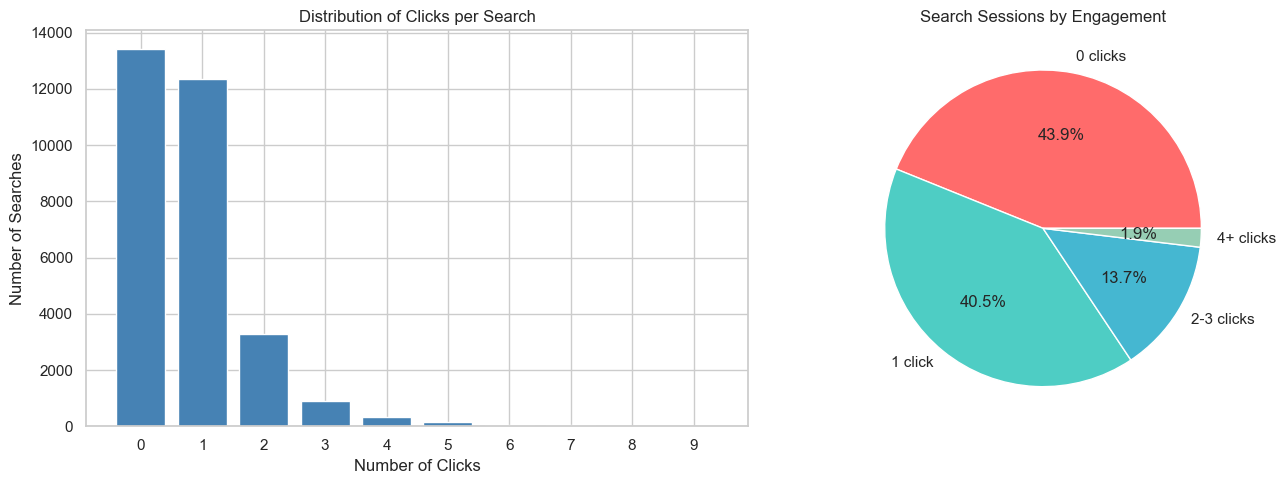

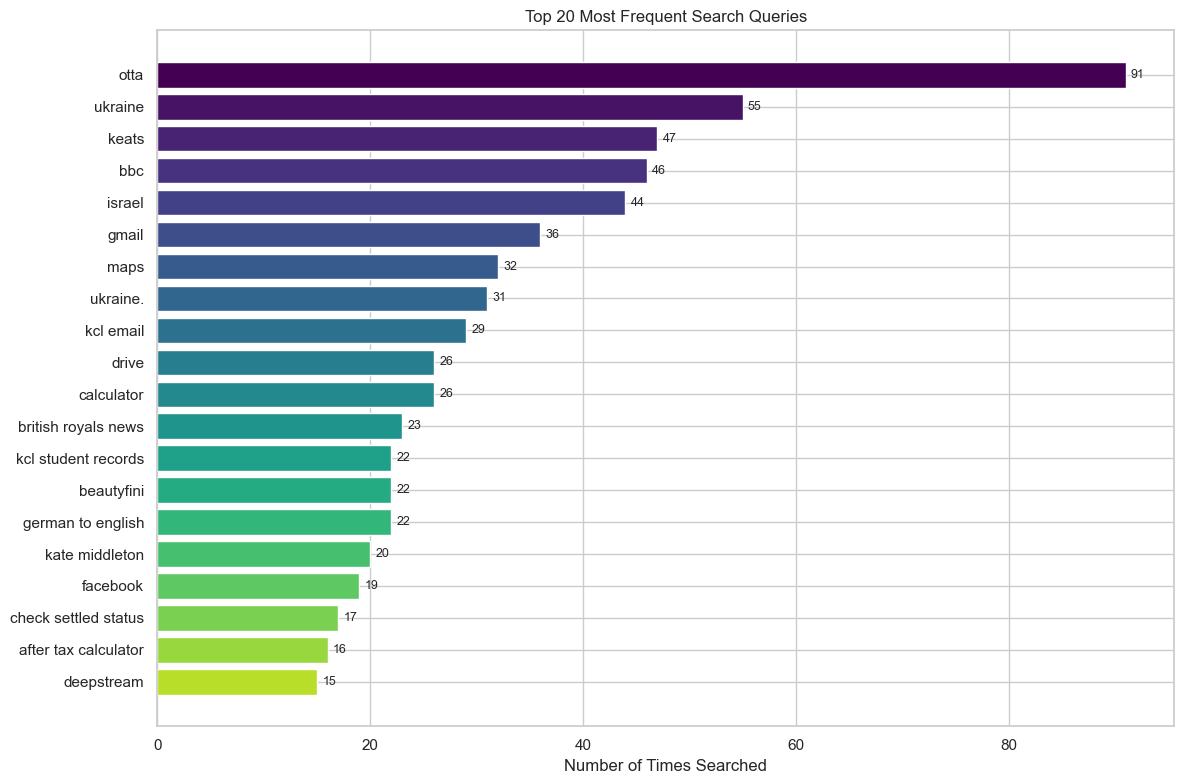

/var/folders/mj/_2jvqgwj66b54vz7j7k_q0br0000gn/T/ipykernel_84155/735565168.py:76: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sessions["year_month"] = sessions["search_time"].dt.to_period("M")


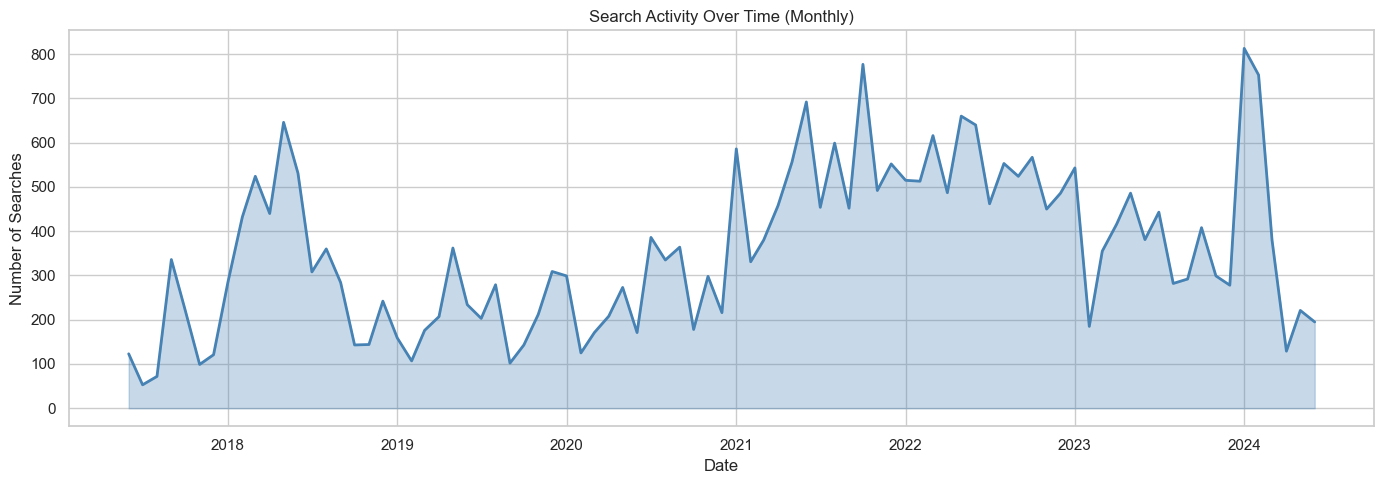

Data spans: 2017-06-08 to 2024-06-23


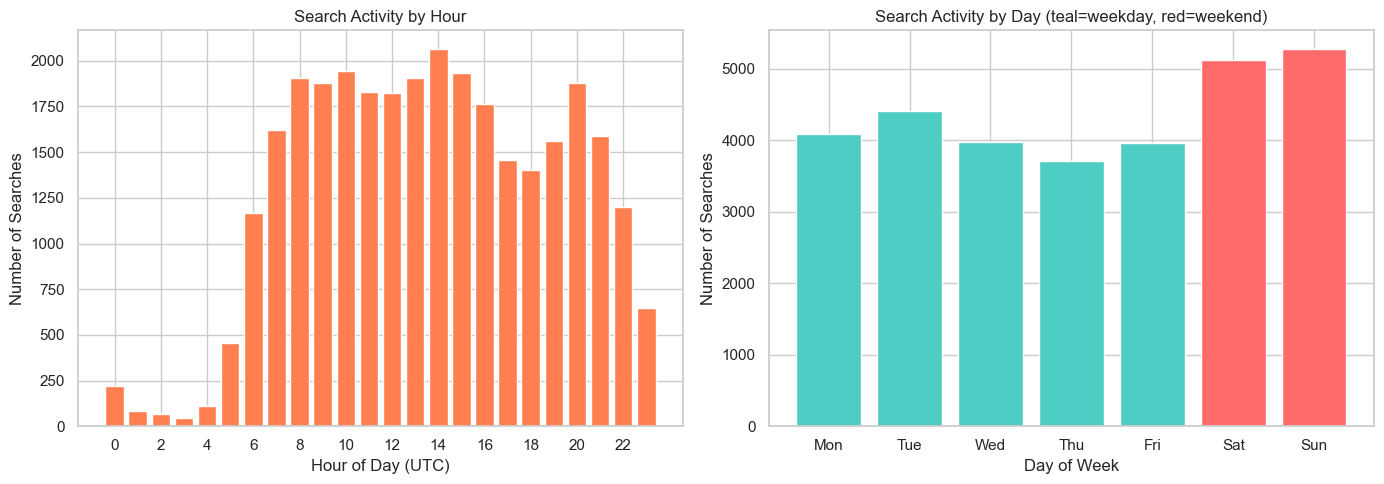

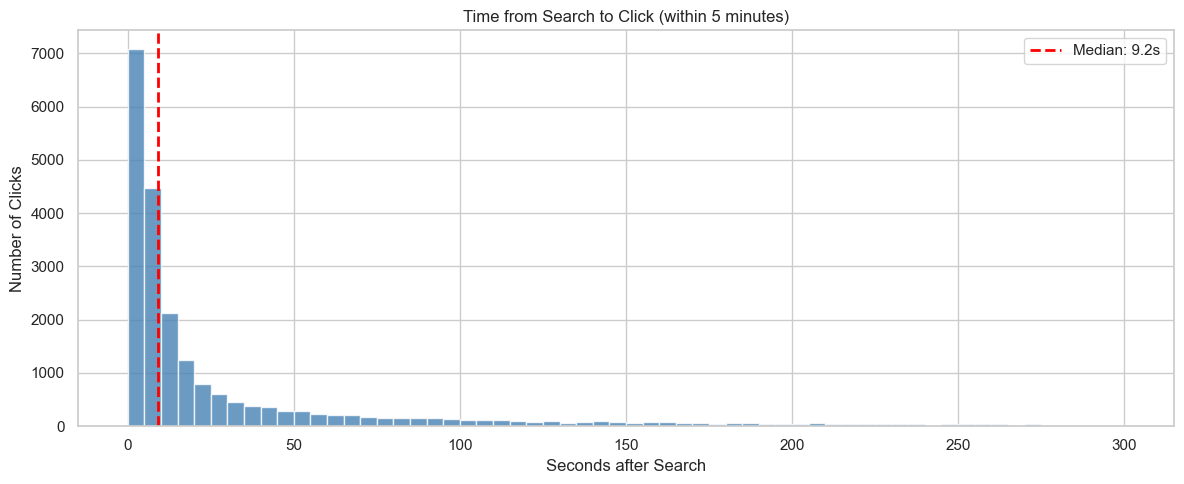


Time-to-Click: Median=9.2s, Mean=32.8s


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# ============================================================
# 1. Create Search Sessions (aggregate by search_id)
# ============================================================
sessions = (
    df[df["search_id"].notna()]
    .groupby("search_id")
    .agg(
        search_query=("search_query", "first"),
        search_time=("search_time", "first"),
        n_clicks=("event_type", lambda x: (x == "click").sum()),
    )
    .reset_index()
)

# Summary stats
print("=" * 60)
print("SEARCH SESSION SUMMARY")
print("=" * 60)
print(f"Total search sessions:     {len(sessions):>10,}")
print(f"Sessions with 1+ clicks:   {(sessions['n_clicks'] > 0).sum():>10,} ({(sessions['n_clicks'] > 0).mean()*100:.1f}%)")
print(f"Sessions with 0 clicks:    {(sessions['n_clicks'] == 0).sum():>10,} ({(sessions['n_clicks'] == 0).mean()*100:.1f}%)")
print(f"Average clicks per search: {sessions['n_clicks'].mean():>10.2f}")
print(f"Max clicks on a search:    {sessions['n_clicks'].max():>10}")
print("=" * 60)

# ============================================================
# 2. Click Distribution
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
ax1 = axes[0]
click_counts = sessions["n_clicks"].value_counts().sort_index()
click_counts = click_counts[click_counts.index < 10]
ax1.bar(click_counts.index, click_counts.values, color='steelblue', edgecolor='white')
ax1.set_xlabel("Number of Clicks")
ax1.set_ylabel("Number of Searches")
ax1.set_title("Distribution of Clicks per Search")
ax1.set_xticks(range(10))

# Right: Pie chart
ax2 = axes[1]
categories = pd.cut(sessions["n_clicks"], bins=[-1, 0, 1, 3, 100], labels=["0 clicks", "1 click", "2-3 clicks", "4+ clicks"])
cat_counts = categories.value_counts()
ax2.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
ax2.set_title("Search Sessions by Engagement")

plt.tight_layout()
plt.show()

# ============================================================
# 3. Top 20 Search Queries
# ============================================================
fig, ax = plt.subplots(figsize=(12, 8))
top_queries = sessions["search_query"].value_counts().head(20)
ax.barh(range(len(top_queries)), top_queries.values, color=plt.cm.viridis(range(0, 256, 256//20)))
ax.set_yticks(range(len(top_queries)))
ax.set_yticklabels(top_queries.index)
ax.invert_yaxis()
ax.set_xlabel("Number of Times Searched")
ax.set_title("Top 20 Most Frequent Search Queries")
for i, v in enumerate(top_queries.values):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=9)
plt.tight_layout()
plt.show()

# ============================================================
# 4. Search Activity Over Time
# ============================================================
fig, ax = plt.subplots(figsize=(14, 5))
sessions["year_month"] = sessions["search_time"].dt.to_period("M")
monthly = sessions.groupby("year_month").size()
monthly.index = monthly.index.to_timestamp()
ax.fill_between(monthly.index, monthly.values, alpha=0.3, color='steelblue')
ax.plot(monthly.index, monthly.values, color='steelblue', linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Searches")
ax.set_title("Search Activity Over Time (Monthly)")
plt.tight_layout()
plt.show()
print(f"Data spans: {sessions['search_time'].min().strftime('%Y-%m-%d')} to {sessions['search_time'].max().strftime('%Y-%m-%d')}")

# ============================================================
# 5. Search Patterns by Hour & Day
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sessions["hour"] = sessions["search_time"].dt.hour
hourly = sessions.groupby("hour").size()
axes[0].bar(hourly.index, hourly.values, color='coral', edgecolor='white')
axes[0].set_xlabel("Hour of Day (UTC)")
axes[0].set_ylabel("Number of Searches")
axes[0].set_title("Search Activity by Hour")
axes[0].set_xticks(range(0, 24, 2))

sessions["dow"] = sessions["search_time"].dt.dayofweek
dow_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
daily = sessions.groupby("dow").size()
colors = ['#4ecdc4' if d < 5 else '#ff6b6b' for d in daily.index]
axes[1].bar(daily.index, daily.values, color=colors, edgecolor='white')
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Number of Searches")
axes[1].set_title("Search Activity by Day (teal=weekday, red=weekend)")
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(dow_names)

plt.tight_layout()
plt.show()

# ============================================================
# 6. Time from Search to Click
# ============================================================
fig, ax = plt.subplots(figsize=(12, 5))
df_clicks = df[df["event_type"] == "click"].copy()
df_clicks["time_to_click"] = (df_clicks["time"] - df_clicks["search_time"]).dt.total_seconds()
reasonable = df_clicks[(df_clicks["time_to_click"] >= 0) & (df_clicks["time_to_click"] <= 300)]

ax.hist(reasonable["time_to_click"], bins=60, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(reasonable["time_to_click"].median(), color='red', linestyle='--', linewidth=2,
           label=f'Median: {reasonable["time_to_click"].median():.1f}s')
ax.set_xlabel("Seconds after Search")
ax.set_ylabel("Number of Clicks")
ax.set_title("Time from Search to Click (within 5 minutes)")
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nTime-to-Click: Median={reasonable['time_to_click'].median():.1f}s, Mean={reasonable['time_to_click'].mean():.1f}s")

In [ ]:
# ============================================================
# Top Search Queries by Year
# ============================================================

# Ensure year column exists in sessions
if "year" not in sessions.columns:
    sessions["year"] = sessions["search_time"].dt.year

years = sorted(sessions["year"].dropna().unique().astype(int))
n_years = len(years)

# Create subplots - one row per year
fig, axes = plt.subplots(n_years, 1, figsize=(14, 5 * n_years))

# Handle case where there's only one year
if n_years == 1:
    axes = [axes]

top_n = 15  # Number of top queries to show per year

for idx, year in enumerate(years):
    ax = axes[idx]
    
    # Get queries for this year
    year_sessions = sessions[sessions["year"] == year]
    top_queries = year_sessions["search_query"].value_counts().head(top_n)
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_queries)))
    ax.barh(range(len(top_queries)), top_queries.values, color=colors)
    ax.set_yticks(range(len(top_queries)))
    ax.set_yticklabels(top_queries.index, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("Number of Times Searched")
    ax.set_title(f"Top {top_n} Search Queries in {year} ({len(year_sessions):,} total searches)", fontsize=12, fontweight='bold')
    
    # Add count labels
    for i, v in enumerate(top_queries.values):
        ax.text(v + 0.3, i, str(v), va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Also show a summary table
print("\n" + "=" * 80)
print("TOP 5 SEARCH QUERIES BY YEAR (Summary)")
print("=" * 80)
for year in years:
    year_sessions = sessions[sessions["year"] == year]
    top_5 = year_sessions["search_query"].value_counts().head(5)
    print(f"\n{year} ({len(year_sessions):,} searches):")
    for i, (query, count) in enumerate(top_5.items(), 1):
        print(f"  {i}. {query[:60]:<60} ({count:>3}x)")

In [6]:
import voyageai
import pickle
from tqdm import tqdm

# vo = voyageai.Client()
# search_queries = sessions["search_query"].dropna().unique().tolist()

# print(f"Total queries to embed: {len(search_queries):,}")

# # Batch the requests (Voyage AI limit is 1000 per request)
# BATCH_SIZE = 1000
# all_embeddings = []

# for i in tqdm(range(0, len(search_queries), BATCH_SIZE), desc="Embedding batches"):
#     batch = search_queries[i:i + BATCH_SIZE]
#     result = vo.embed(batch, model="voyage-3-lite", input_type="document")
#     all_embeddings.extend(result.embeddings)

# print(f"Total embeddings: {len(all_embeddings)}")

# # Save the embeddings to a pickle file
# with open("search_query_embeddings.pkl", "wb") as f:
#     pickle.dump({"queries": search_queries, "embeddings": all_embeddings}, f)

# print("Saved to search_query_embeddings.pkl")

# # ! embed the time and click times

In [13]:
# load the embeddings from the pickle file
with open("search_query_embeddings.pkl", "rb") as f:
    data = pickle.load(f)
    search_queries = data["queries"]
    embeddings = data["embeddings"]

print(f"Loaded {len(search_queries):,} queries and {len(embeddings):,} embeddings")

# Create a mapping from query to embedding id (index in the search_queries list)
query_to_embedding_id = {query: idx for idx, query in enumerate(search_queries)}

# Add embedding_id column to df by mapping search_query
df["embedding_id"] = df["search_query"].map(query_to_embedding_id)

print(f"Added embedding_id column to df: {df['embedding_id'].notna().sum():,} rows have embeddings")
df

Loaded 25,850 queries and 25,850 embeddings
Added embedding_id column to df: 55,383 rows have embeddings


header                                              title  \
0      Search                                 Searched for gmail   
1      Search              Visited https://www.google.com/gmail/   
2      Search  Searched for investment banking networking eve...   
3      Search  Visited http://news.efinancialcareers.com/uk-e...   
4      Search   Searched for blackstone's women networking event   
...       ...                                                ...   
55378  Search                          Searched for jubilee line   
55379  Search                             Searched for gladiator   
55380  Search                 Searched for myrdle court postcode   
55381  Search  Visited http://mashable.com/2012/10/18/monthly...   
55382  Search  Visited Personal Cloud Storage & File Sharing ...   

                                                titleUrl  \
0                  https://www.google.com/search?q=gmail   
1                          https://www.google.com/gmail/   
2      https://www.google.com/search?q=investment+ban...   
3      https://www.google.com/url?q=http://news.efina...   
4      https://www.google.com/search?q=blackstone%27s...   
...                                                  ...   
55378       https://www.google.com/search?q=jubilee+line   
55379          https://www.google.com/search?q=gladiator   
55380  https://www.google.com/search?q=myrdle+court+p...   
55381  https://www.google.com/url?q=http://mashable.c...   
55382                      https://www.google.com/drive/   

                                  time  products      activityControls  \
0     2017-06-08 16:42:55.223000+00:00  [Search]  [Web & App Activity]   
1     2017-06-08 16:42:57.355000+00:00  [Search]  [Web & App Activity]   
2     2017-06-08 16:45:50.139000+00:00  [Search]  [Web & App Activity]   
3     2017-06-08 16:45:58.449000+00:00  [Search]  [Web & App Activity]   
4     2017-06-08 16:48:12.167000+00:00  [Search]  [Web & App Activity]   
...                                ...       ...                   ...   
55378                              NaT  [Search]  [Web & App Activity]   
55379                              NaT  [Search]  [Web & App Activity]   
55380                              NaT  [Search]  [Web & App Activity]   
55381                              NaT  [Search]  [Web & App Activity]   
55382                              NaT  [Search]  [Web & App Activity]   

      locationInfos subtitles details event_type  search_id  \
0               NaN       NaN     NaN     search          1   
1               NaN       NaN     NaN      click          1   
2               NaN       NaN     NaN     search          2   
3               NaN       NaN     NaN      click          2   
4               NaN       NaN     NaN     search          3   
...             ...       ...     ...        ...        ...   
55378           NaN       NaN     NaN     search      30540   
55379           NaN       NaN     NaN     search      30541   
55380           NaN       NaN     NaN     search      30542   
55381           NaN       NaN     NaN      click      30542   
55382           NaN       NaN     NaN      click      30542   

                                      search_query  \
0                                            gmail   
1                                            gmail   
2      investment banking networking events london   
3      investment banking networking events london   
4              blackstone's women networking event   
...                                            ...   
55378                                 jubilee line   
55379                                    gladiator   
55380                        myrdle court postcode   
55381                        myrdle court postcode   
55382                        myrdle court postcode   

                           search_time  \
0     2017-06-08 16:42:55.223000+00:00   
1     2017-06-08 16:42:55.223000+00:00   
2     2017-06-08 16:45:50.139000+00:00   
3     

/Users/joeyxiong/Desktop/code/onfabric-data-science-interview/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


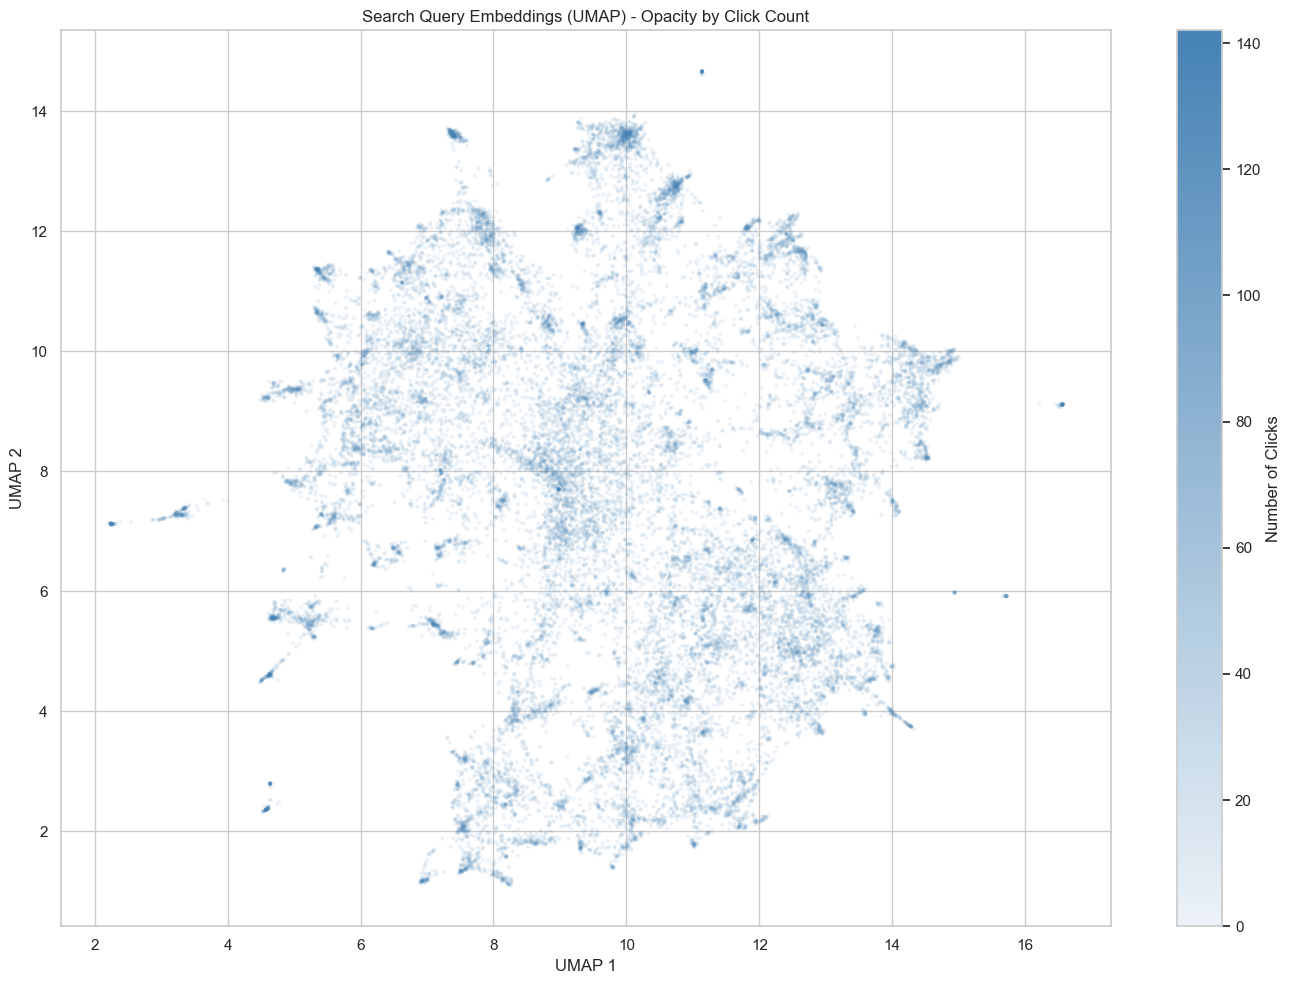

Click count stats: min=0, max=142, mean=0.95


In [ ]:
# Visualize embeddings with UMAP, colored by number of clicks
import umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Convert embeddings to numpy array
embeddings_array = np.array(embeddings)

# Aggregate clicks per unique query
clicks_per_query = sessions.groupby("search_query")["n_clicks"].sum().to_dict()
click_counts = np.array([clicks_per_query.get(q, 0) for q in search_queries])

# Reduce to 2D with UMAP (do this once, reuse for all plots)
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = reducer.fit_transform(embeddings_array)

# Create a custom colormap from transparent to opaque steelblue
steelblue = (0.27, 0.51, 0.71)
cmap_colors = [(steelblue[0], steelblue[1], steelblue[2], 0.1),
    (steelblue[0], steelblue[1], steelblue[2], 1.0)]
cmap = LinearSegmentedColormap.from_list("steelblue_alpha", cmap_colors)

# Sort by clicks so high-click points are drawn on top
sort_idx = np.argsort(click_counts)

# Single plot with all data
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    embeddings_2d[sort_idx, 0], 
    embeddings_2d[sort_idx, 1], 
    c=click_counts[sort_idx],
    cmap=cmap,
    s=8,
    edgecolors='none',
    vmin=0,
    vmax=click_counts.max()
)
plt.colorbar(scatter, ax=ax, label='Number of Clicks')
ax.set_title("Search Query Embeddings (UMAP) - Opacity by Click Count")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

print(f"Click count stats: min={click_counts.min()}, max={click_counts.max()}, mean={click_counts.mean():.2f}")

In [11]:
# Interactive UMAP by Year with hover - using Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Defensive: if 'year' column missing, create it from 'search_time'
if "year" not in sessions.columns:
    if "search_time" in sessions.columns:
        # Try to convert to datetime just in case
        sessions["search_time"] = pd.to_datetime(sessions["search_time"], errors="coerce")
        sessions["year"] = sessions["search_time"].dt.year
    else:
        raise ValueError("Cannot create 'year' column: 'search_time' is missing.")

# Create mapping from query to index
query_to_idx = {q: i for i, q in enumerate(search_queries)}

# Get years present in data
years = sorted(sessions["year"].dropna().unique().astype(int))
n_years = len(years)
n_cols = 3
n_rows = (n_years + n_cols - 1) // n_cols

# Create subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=[f"{year}" for year in years],
    horizontal_spacing=0.05,
    vertical_spacing=0.08
)

for i, year in enumerate(years):
    row = i // n_cols + 1
    col = i % n_cols + 1

    # Get queries searched in this year
    year_queries = sessions[sessions["year"] == year]["search_query"].unique()
    year_indices = [query_to_idx[q] for q in year_queries if q in query_to_idx]

    # Get click counts for hover info
    year_clicks = sessions[sessions["year"] == year].groupby("search_query")["n_clicks"].sum().to_dict()

    # Background: all points (no hover)
    fig.add_trace(
        go.Scattergl(
            x=embeddings_2d[:, 0],
            y=embeddings_2d[:, 1],
            mode='markers',
            marker=dict(size=2, color='lightgray', opacity=0.3),
            hoverinfo='skip',
            showlegend=False
        ),
        row=row, col=col
    )

    # Foreground: this year's queries with hover
    if len(year_indices) > 0:
        year_points = embeddings_2d[year_indices]
        hover_queries = [search_queries[idx] for idx in year_indices]
        hover_clicks = np.array([year_clicks.get(search_queries[idx], 0) for idx in year_indices])

        # Calculate opacity: 0 clicks = 0 (transparent), max clicks = 1 (opaque)
        max_clicks = hover_clicks.max() if hover_clicks.max() > 0 else 1
        opacities = hover_clicks / max_clicks  # 0 to 1
        # Add small minimum opacity so points with few clicks are still slightly visible
        opacities = 0.05 + 0.95 * opacities

        fig.add_trace(
            go.Scattergl(
                x=year_points[:, 0],
                y=year_points[:, 1],
                mode='markers',
                marker=dict(size=6, color='steelblue', opacity=opacities),
                text=[f"Query: {q}<br>Clicks: {c}" for q, c in zip(hover_queries, hover_clicks)],
                hovertemplate='%{text}<extra></extra>',
                showlegend=False
            ),
            row=row, col=col
        )

fig.update_layout(
    title=dict(text="Search Query Embeddings by Year (Hover for details)", x=0.5),
    height=600 * n_rows,
    width=1800,
    showlegend=False
)

# Remove axis labels for cleaner look
fig.update_xaxes(showticklabels=False, title_text="")
fig.update_yaxes(showticklabels=False, title_text="")

fig.show()

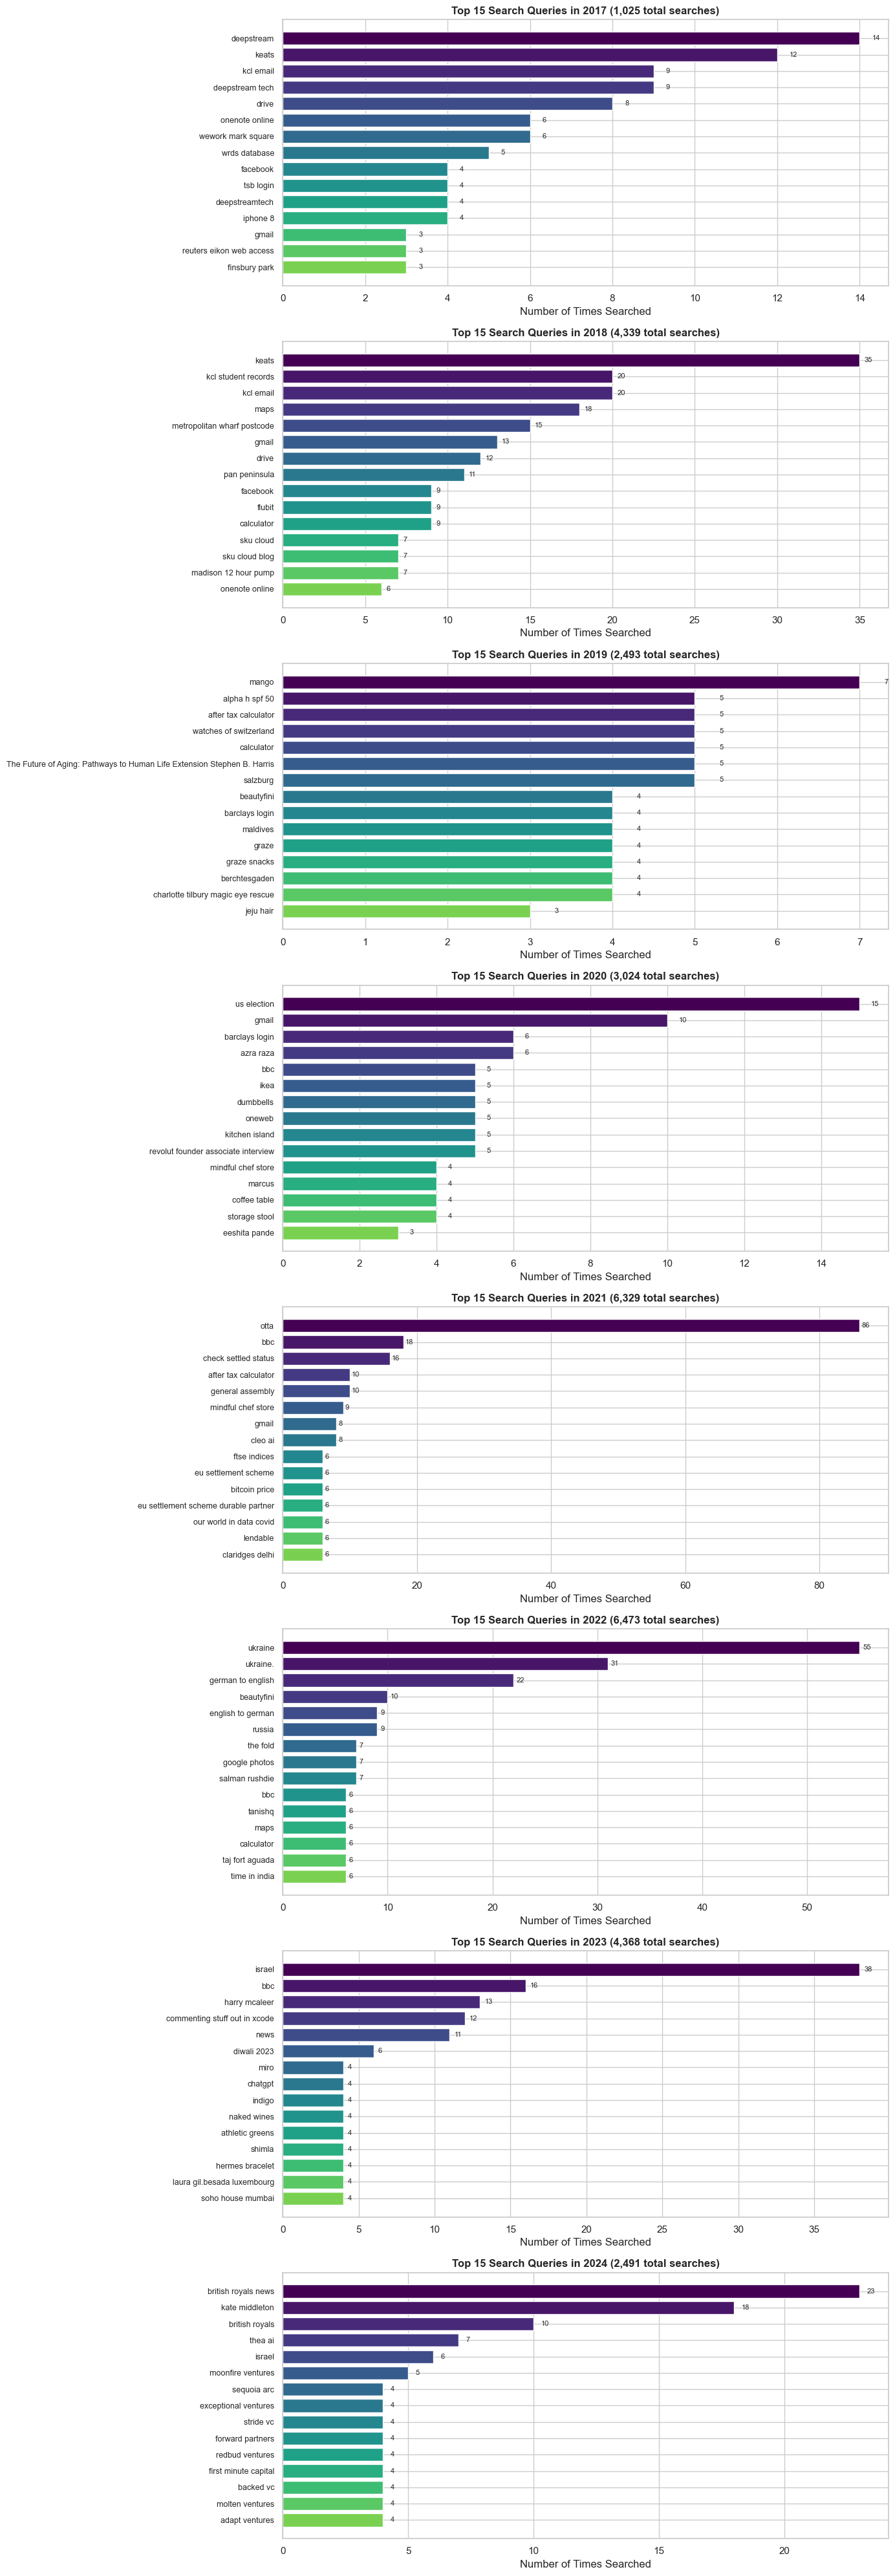


TOP 5 SEARCH QUERIES BY YEAR (Summary)

2017 (1,025 searches):
  1. deepstream                                                   ( 14x)
  2. keats                                                        ( 12x)
  3. kcl email                                                    (  9x)
  4. deepstream tech                                              (  9x)
  5. drive                                                        (  8x)

2018 (4,339 searches):
  1. keats                                                        ( 35x)
  2. kcl student records                                          ( 20x)
  3. kcl email                                                    ( 20x)
  4. maps                                                         ( 18x)
  5. metropolitan wharf postcode                                  ( 15x)

2019 (2,493 searches):
  1. mango                                                        (  7x)
  2. alpha h spf 50                                               (  5x)
  3. after t

In [ ]:
# ============================================================
# Top Search Queries by Year
# ============================================================

# Ensure year column exists in sessions
if "year" not in sessions.columns:
    sessions["year"] = sessions["search_time"].dt.year

years = sorted(sessions["year"].dropna().unique().astype(int))
n_years = len(years)

# Create subplots - one row per year
fig, axes = plt.subplots(n_years, 1, figsize=(14, 5 * n_years))

# Handle case where there's only one year
if n_years == 1:
    axes = [axes]

top_n = 15  # Number of top queries to show per year

for idx, year in enumerate(years):
    ax = axes[idx]
    
    # Get queries for this year
    year_sessions = sessions[sessions["year"] == year]
    top_queries = year_sessions["search_query"].value_counts().head(top_n)
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_queries)))
    ax.barh(range(len(top_queries)), top_queries.values, color=colors)
    ax.set_yticks(range(len(top_queries)))
    ax.set_yticklabels(top_queries.index, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("Number of Times Searched")
    ax.set_title(f"Top {top_n} Search Queries in {year} ({len(year_sessions):,} total searches)", fontsize=12, fontweight='bold')
    
    # Add count labels
    for i, v in enumerate(top_queries.values):
        ax.text(v + 0.3, i, str(v), va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Also show a summary table
print("\n" + "=" * 80)
print("TOP 5 SEARCH QUERIES BY YEAR (Summary)")
print("=" * 80)
for year in years:
    year_sessions = sessions[sessions["year"] == year]
    top_5 = year_sessions["search_query"].value_counts().head(5)
    print(f"\n{year} ({len(year_sessions):,} searches):")
    for i, (query, count) in enumerate(top_5.items(), 1):
        print(f"  {i}. {query[:60]:<60} ({count:>3}x)")

In [ ]:
{
    "embedding id 1": {
        [{
            "header": "Search",
            "title": "Visited https://www.businessinsider.com/shivon-zilis-reported-mother-elon-musk-twins-2022-7?amp",
            "titleUrl": "https://www.google.com/url?q\u003dhttps://www.businessinsider.com/shivon-zilis-reported-mother-elon-musk-twins-2022-7%3Famp\u0026usg\u003dAOvVaw1JpQbDqah1O4c5A5wg4Who",
            "time": "2024-06-23T22:21:50.431Z",
            "products": ["Search"],
            "activityControls": ["Web \u0026 App Activity"]
            },{
            "header": "Search",
            "title": "Visited Elon Musk and Shivon Zilis privately welcome third baby – NBC10 ...",
            "titleUrl": "https://www.google.com/url?q\u003dhttps://www.nbcphiladelphia.com/entertainment/entertainment-news/elon-musk-and-shivon-zilis-privately-welcome-third-baby/3892694/\u0026usg\u003dAOvVaw0BqY5StEFFTmHdppOUNY4V",
            "time": "2024-06-23T22:20:53.934Z",
            "products": ["Search"],
            "activityControls": ["Web \u0026 App Activity"]
        }]
    },
    "embedding id 2": {
        "query": "query",
        "clicks": 2,
        "visited": 1,
        "viewed": 1,
        "defined": 0
    }
}
